### Import Libraries

In [159]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from tqdm import tqdm
import random


cwd = os.getcwd()

### Open Dataset and Data review

In [160]:
data_dir = os.path.join(cwd, 'data/')
data = pd.read_csv(os.path.join(data_dir, 'log2.csv'))
data.head(10)

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
5,51465,443,39975,443,allow,3961,1595,2366,21,16,12,9
6,60513,47094,45469,47094,allow,320,140,180,6,7,3,3
7,50049,443,21285,443,allow,7912,3269,4643,23,96,12,11
8,52244,58774,2211,58774,allow,70,70,0,1,5,1,0
9,50627,443,16215,443,allow,8256,1674,6582,31,75,15,16


In [161]:
data.dtypes

Source Port              int64
Destination Port         int64
NAT Source Port          int64
NAT Destination Port     int64
Action                  object
Bytes                    int64
Bytes Sent               int64
Bytes Received           int64
Packets                  int64
Elapsed Time (sec)       int64
pkts_sent                int64
pkts_received            int64
dtype: object

In [162]:
data.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

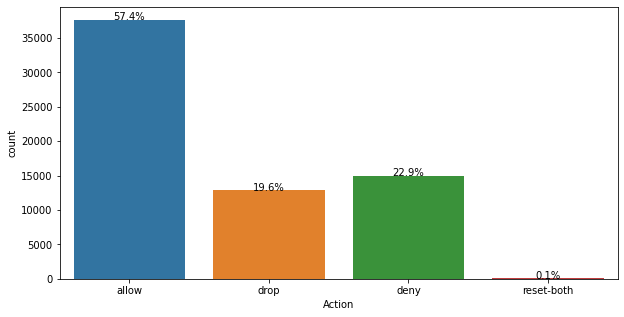

In [163]:
def count_plot(data, col):
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=col, data=data)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / len(data[col]))
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y),ha='center')
    plt.show()

def scatter_plot(data, col1, col2):
    plt.figure(figsize=(10,5))
    ax = sns.scatterplot(x=col1, y=col2, data=data)
    plt.show()

count_plot(data, 'Action')

### Data preprocessing and Data cleaning

In [164]:
# declare utility functions
def normalized(dataset, colmun):
    dataset[colmun] = MinMaxScaler(feature_range=(0, 1)).fit_transform(dataset[colmun].values.reshape(-1,1))
    return dataset

def onehot_encode(dataset, column):
    onehot = pd.get_dummies(dataset[column], prefix="{}_".format(column), prefix_sep="")
    dataset = pd.concat([dataset, onehot], axis=1)
    dataset = dataset.drop(column, axis=1)
    return dataset

def label_encode(dataset, column):
    le = LabelEncoder()
    dataset[column] = le.fit_transform(dataset[column])
    return dataset

def show_corr(dataset):
    plt.figure(figsize=(25,20))
    corr = dataset.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
    plt.show()

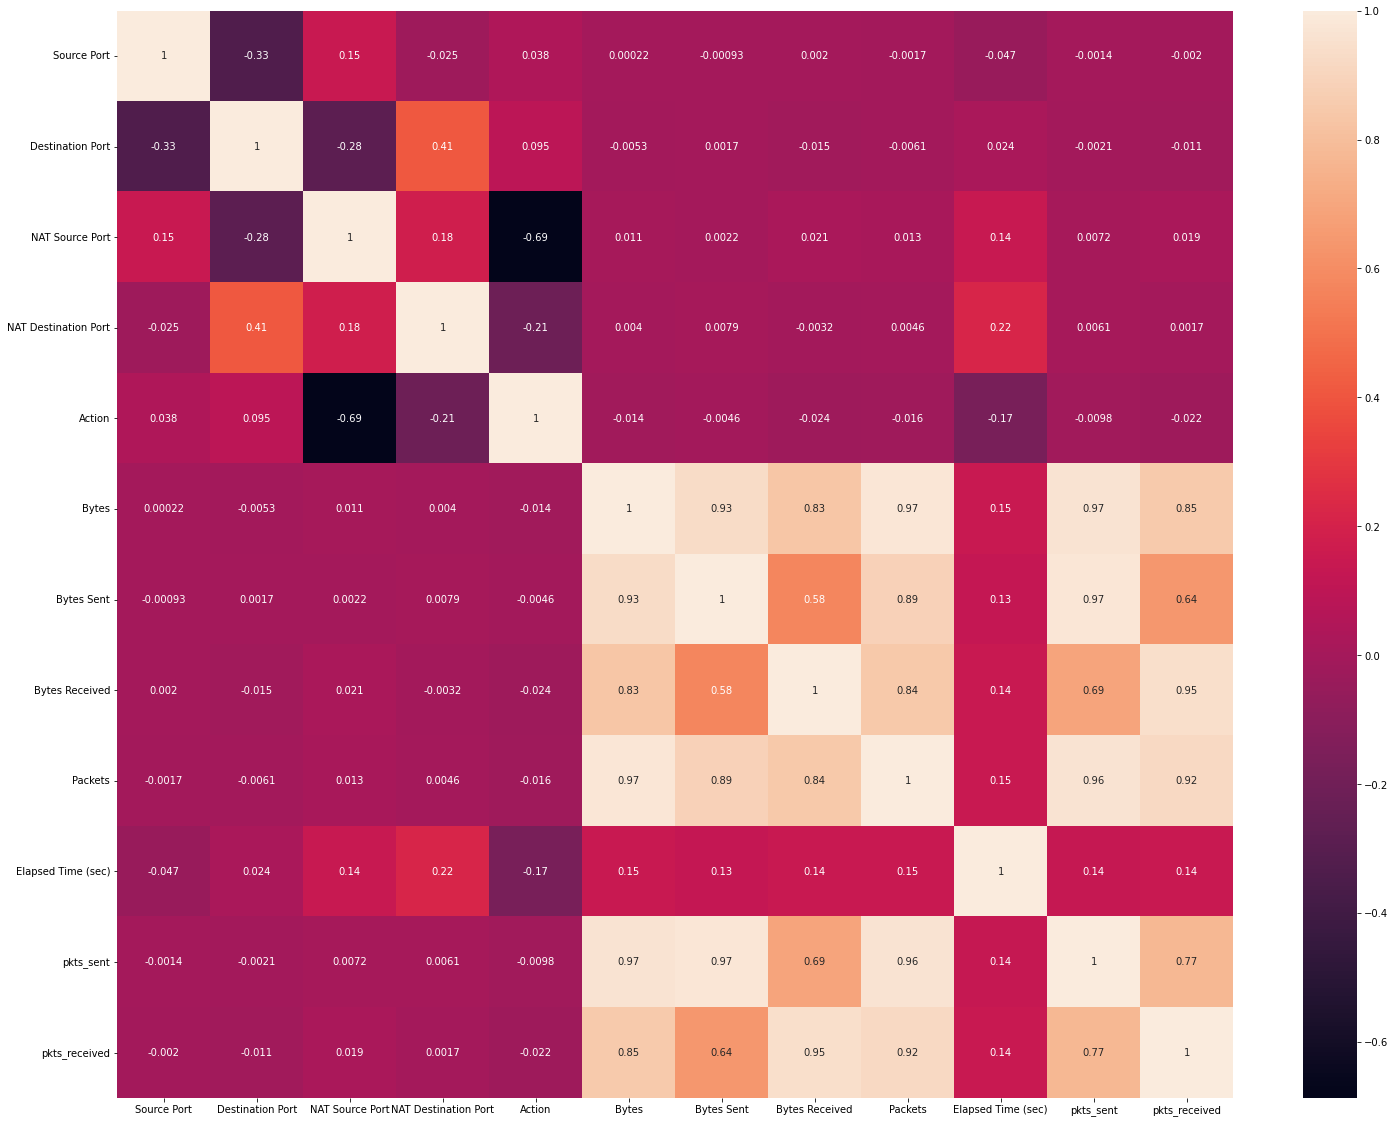

In [165]:
# numeric column processing
# for i in ["Source Port", "Destination Port", "NAT Source Port", "NAT Destination Port", "Bytes", "Bytes Sent", "Bytes Received", "Packets", "Elapsed Time (sec)", "pkts_sent", "pkts_received"]:
#     data = normalized(data, i)

# binary field processing
for i in ["Action"]:
    data = label_encode(data, i)

show_corr(data)

In [166]:
data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,0,177,94,83,2,30,1,1
1,56258,3389,56258,3389,0,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,0,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,0,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,0,25358,6778,18580,31,16,13,18


In [167]:
data.dtypes

Source Port             int64
Destination Port        int64
NAT Source Port         int64
NAT Destination Port    int64
Action                  int32
Bytes                   int64
Bytes Sent              int64
Bytes Received          int64
Packets                 int64
Elapsed Time (sec)      int64
pkts_sent               int64
pkts_received           int64
dtype: object

### Split train/test set

In [168]:
target, feature = data['Action'], data.drop(columns=['Action'], axis=1)
print(f"data shape: {data.shape}")
print(f"feature(x-axis) shape: {feature.shape}")
print(f"target(y-axis) shape: {target.shape}")

x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.25, random_state=random.randint(0,100))

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

data shape: (65532, 12)
feature(x-axis) shape: (65532, 11)
target(y-axis) shape: (65532,)
x_train shape: (49149, 11)
x_test shape: (16383, 11)
y_train shape: (49149,)
y_test shape: (16383,)


### Baseline classfication accuracy

In [169]:
# 此處使用 DummyClassifier 做為基準模型
# 將策略指定為 'most_frequent'
# 在這個策略下，模型總是回傳最頻繁出現的y-axis值
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(x_train, y_train)
baseAcc = dummy.score(x_test, y_test)
print(f"baseline Acc: {baseAcc}")

baseline Acc: 0.5757187328328145


### Model Traning!!

In [170]:
estimator_range = range(1, 101)

### Method 1: Random Forest Model

100%|██████████| 100/100 [02:13<00:00,  1.33s/it]

[Random Forest] max score 0.9989623390099494 at 17


Text(0, 0.5, 'Accuracy')

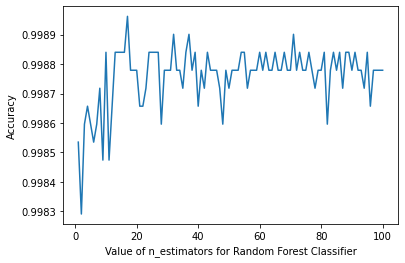

In [171]:
max_score_rfc, max_k_rfc = -1, -1

score_rfc = []
for k in tqdm(estimator_range):
    rfc = RandomForestClassifier(n_estimators=k)
    rfc.fit(x_train, y_train)
    score_rfc.append(rfc.score(x_test, y_test))
    if score_rfc[-1] > max_score_rfc:
        max_score_rfc, max_k_rfc = score_rfc[-1], k

print(f"[Random Forest] max score {max_score_rfc} at {max_k_rfc}")

plt.plot(estimator_range, score_rfc)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Accuracy')

In [172]:
rfc = RandomForestClassifier(n_estimators=max_k_rfc, random_state=42)
rfc.fit(x_train, y_train)
rfc_predict = rfc.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, rfc_predict)}")

Accuracy: 0.9987792223646462


In [173]:
# find feature importance in RandomForestClassifier
feature_importance = pd.DataFrame(rfc.feature_importances_, index=feature.columns, 
                                                            columns=['importance'])
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.head(10)

,importance
Destination Port,0.231775
NAT Destination Port,0.194041
Elapsed Time (sec),0.166935
NAT Source Port,0.109219
Packets,0.068306
Bytes,0.062970
pkts_received,0.061301
Bytes Sent,0.043004
Source Port,0.031455
Bytes Received,0.030289


### Method 2: Ada Boost Model

100%|██████████| 100/100 [39:44<00:00, 23.84s/it]

[Ada Boost] max score 0.9989013001281817 at 42


Text(0, 0.5, 'Accuracy')

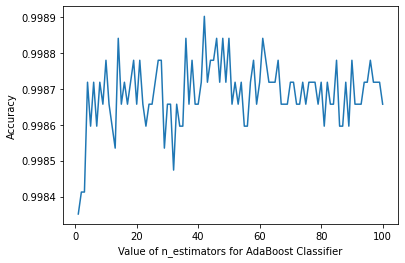

In [174]:
base_est2 = DecisionTreeClassifier()

max_score_ada, max_k_ada = -1, -1

score_ada = []
for k in tqdm(estimator_range):
    ada = AdaBoostClassifier(base_estimator=base_est2, n_estimators=k)
    ada.fit(x_train, y_train)
    score_ada.append(ada.score(x_test, y_test))
    if score_ada[-1] > max_score_ada:
        max_score_ada, max_k_ada = score_ada[-1], k

print(f"[Ada Boost] max score {max_score_ada} at {max_k_ada}")

plt.plot(estimator_range, score_ada)
plt.xlabel('Value of n_estimators for AdaBoost Classifier')
plt.ylabel('Accuracy')

### Make Classifier Together!

In [179]:
rfc = RandomForestClassifier(n_estimators=max_k_rfc)
ada = AdaBoostClassifier(base_estimator=base_est2, n_estimators=max_k_ada)

voting = VotingClassifier(estimators=[('rfc', rfc), ('ada', ada)], voting='soft')
voting.fit(x_train, y_train)
voting_predict = voting.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, voting_predict)}")

Accuracy: 0.9987792223646462
